# Identify Spoken Digits

In [ ]:
# If additional packages are needed but are not installed by default, uncomment the last two lines of this cell
# and replace <package list> with a list of additional packages.
# This will ensure the notebook has all the dependencies and works everywhere

#import sys
#!{sys.executable} -m pip install <package list>

In [ ]:
import sys
!{sys.executable} -m pip install wget tensorflow librosa

In [2]:
# Libraries
import pandas as pd
import numpy as np
import wget
import os
from shutil import unpack_archive
from IPython.display import Audio
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

pd.set_option("display.max_columns", 101)
pd.set_option('display.max_colwidth', 100)

In [ ]:
# Run this cell block to download and extract dataset
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/eoipkqn29dp/fe7b2969049b9f22aac686ce36edcb68/train_0.zip'
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/eoipkqn29dp/43d7ad3a79db982ad408bfe1d636bc2c/train_1.zip'
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/eoipkqn29dp/7f7e6e603f9e864dc860afe7773e480b/train_2.zip'
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/eoipkqn29dp/4ee8303aa9d7a4ae17292075bf16ec2a/train_3.zip'
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/eoipkqn29dp/ef8d739f1d67e1270b670c2769593a09/test.zip'

print('Extracting Train Dataset:')
unpack_archive('train_0.zip', '')
unpack_archive('train_1.zip', '')
unpack_archive('train_2.zip', '')
unpack_archive('train_3.zip', '')

print('Extracting Test Dataset:')
unpack_archive('test.zip', '')

# Remove zip files
os.remove('train_0.zip')
os.remove('train_1.zip')
os.remove('train_2.zip')
os.remove('train_3.zip')
os.remove('test.zip')

Extracting Train Dataset:
Extracting Test Dataset:


''

## Data Description

Column | Description
:---|:---
`path` | Path of the Audio Clip
`label` | Label of the Audio Clip (`0` - `zero`, `1` - `one`, `2` - `two`, `3` - `three`)

In [6]:
# The information dataset for the training set is already loaded below
data = pd.read_csv('train.csv')
data.head()

,path,label
0,train_2/0.wav,2
1,train_3/1.wav,3
2,train_2/2.wav,2
3,train_3/3.wav,3
4,train_3/4.wav,3


### Sample Audio Clips
In the following cells, we load some sample audio clips of each class.

In [7]:
# zero
filename_zero = data.loc[data['label'] == 0, 'path'].iloc[0]
Audio(filename_zero)

In [8]:
# one
filename_one = data.loc[data['label'] == 1, 'path'].iloc[0]
Audio(filename_one)

In [9]:
# two
filename_two = data.loc[data['label'] == 2, 'path'].iloc[0]
Audio(filename_two)

In [10]:
# three
filename_three = data.loc[data['label'] == 3, 'path'].iloc[0]
Audio(filename_three)

## Deep Learning

Build a neural network that can predict the label of the audio clip.
- **The model's performance will be evaluated on the basis of weighted F1-score.**

### Prepare Data

*   We first shuffle the data to remove any positional datapoint bias.
*   Then, we split the training data into training and validation sets with a 80:20 split ratio.
*   Then, we create tensorflow custom training and validation datasets that will be used to train our model.

In order to create the tensorflow datasets, we define some utility functions which collectively do the following:
*   Load the audio files and corresponding labels using tensorflow IO.
*   Decode the loaded audio files into raw waveforms.
*   Convert the raw waveforms to fixed size Mel spectrograms. We define the short-term fourier transform parameters in such a way that output spectrogram images are almost square in shape.
*   Since the Mel spectrograms are 1 channel images, we explicitly convert them into 3 channel images so that we can feed them into our models.

Finally, we get 129x129 images as output. These images are the normalized Mel spectrograms which we will use to train our model.


In [11]:
# shuffle data
data = data.sample(frac=1).reset_index(drop=True)

# create training and validation dataframes
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [12]:
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [13]:
# utility function to decode the loaded audio into raw waveforms
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

# utility function to load the audio and get the raw waveform
def get_waveform_and_label(file_path, label):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

# utility function to generate the Mel spectrogram from the raw waveform
def get_spectrogram_and_label(waveform, label):
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.tile(tf.expand_dims(tf.abs(tf.signal.stft(equal_length, frame_length=254, frame_step=123)), -1), tf.constant([1, 1, 3], tf.int32))
    return spectrogram, label

# utility function to create the tensorflow dataset
def prepare_dataset(data_df):
    files = data_df['path'].tolist()
    labels = data_df['label'].tolist()
    files_ds = tf.data.Dataset.from_tensor_slices((files, labels))
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=-1)
    output_ds = output_ds.map(get_spectrogram_and_label,  num_parallel_calls=-1)
    return output_ds

In [14]:
# create tensorflow datasets for training and validation dataframes
dataset_train = prepare_dataset(train_data)
dataset_val = prepare_dataset(val_data)

In [15]:
# cache the datasets for faster loading during training and validation
dataset_train = dataset_train.cache().prefetch(-1)
dataset_val = dataset_val.cache().prefetch(-1)

We plot a few sample spectrograms from the transformed training and validations datasets to check if the dataset formations are correct.

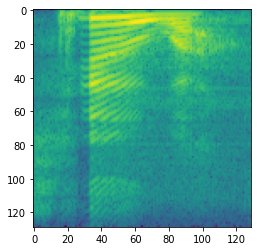

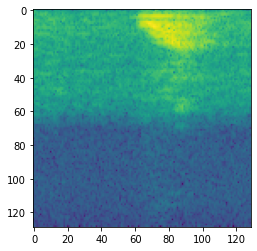

In [16]:
# plot sample training spectrograms
for spectrogram, _ in dataset_train.take(1):
    fig, ax = plt.subplots(1, 1)
    log_spec = np.log(spectrogram[:, :, 0].numpy().T)
    ax.imshow(log_spec)
    plt.show()
    
# plot sample validation spectrograms
for spectrogram, _ in dataset_val.take(1):
    fig, ax = plt.subplots(1, 1)
    log_spec = np.log(spectrogram[:, :, 0].numpy().T)
    ax.imshow(log_spec)
    plt.show()

Now we create batched training and validation datasets from our tensorflow datasets. We set the batch size as 32.

In [17]:
# create batched training and validation datasets
batch_size = 32
dataset_train_batched = dataset_train.batch(batch_size)
dataset_val_batched = dataset_val.batch(batch_size)

We print the shape of the batches to make sure that the batching work as expected.

In [18]:
# print shape of training batches
for waveform_batch, label_batch in dataset_train_batched.take(1):
    print(f'Train Waveform Batch Shape: {waveform_batch.shape}')
    print(f'Train Label Batch Shape: {label_batch.shape}')

# print shape of validation batches
for waveform_batch, label_batch in dataset_val_batched.take(1):
    print(f'Validation Waveform Batch Shape: {waveform_batch.shape}')
    print(f'Validation Label Batch Shape: {label_batch.shape}')

Train Waveform Batch Shape: (32, 129, 129, 3)
Train Label Batch Shape: (32,)
Validation Waveform Batch Shape: (32, 129, 129, 3)
Validation Label Batch Shape: (32,)


### Prepare and Train Model
> #### Task:
- **Use the processed data to build train a deep learning model using tensorflow**

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the 'label' variable.  You should submit a CSV file with a header row and one row per test entry. 

The file (`submissions.csv`) should have exactly 2 columns:

Column | Description
:---|:---
`path` | Path of the Audio Clip
`label` | Label of the Audio Clip (`0` - `zero`, `1` - `one`, `2` - `two`, `3` - `three`)

In [19]:
test = pd.read_csv('test.csv')
test.head()

,path
0,test/0.wav
1,test/1.wav
2,test/2.wav
3,test/3.wav
4,test/4.wav


### Prepare Data
Similar to the train data, we prepare the test data.

In [20]:
# utility function to load the audio and get the raw waveform
def get_waveform(file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform

# utility function to generate the Mel spectrogram from the raw waveform
def get_spectrogram(waveform):
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.tile(tf.expand_dims(tf.abs(tf.signal.stft(equal_length, frame_length=254, frame_step=123)), -1), tf.constant([1, 1, 3], tf.int32))
    return spectrogram

# utility function to create the tensorflow test dataset
def prepare_test_dataset(data_df):
    files = data_df['path'].tolist()
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform, num_parallel_calls=-1)
    output_ds = output_ds.map(get_spectrogram,  num_parallel_calls=-1)
    return output_ds

In [21]:
# create tensorflow test dataset and cache it for faster loading
dataset_test = prepare_test_dataset(test)
dataset_test = dataset_test.cache().prefetch(-1)

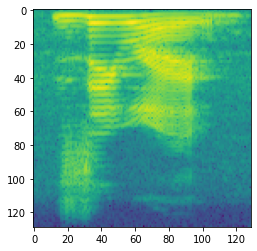

In [22]:
# plot sample testing spectrogram for sanity check
for spectrogram in dataset_test.take(1):
    fig, ax = plt.subplots(1, 1)
    log_spec = np.log(spectrogram[:, :, 0].numpy().T)
    ax.imshow(log_spec)
    plt.show()

In [23]:
# create bacthed testing dataset
dataset_test_batched = dataset_test.batch(batch_size)

In [24]:
# print sample testing batch shape for sanity check
for waveform_batch in dataset_test_batched.take(1):
    print(f'Test Waveform Batch Shape: {waveform_batch.shape}')

Test Waveform Batch Shape: (32, 129, 129, 3)


### Generate Predictions
> #### Task:
- **Write the code to generate predictions on the test data.**

In [ ]:
#Submission
submission_df.to_csv('submissions.csv', index=False)